```bash
Data folder format:
data  
  ├── test  
  │   ├── noise  
  │   └── orca  
  ├── train  
  │   ├── noise  
  │   └── orca  
  └── val  
    ├── noise  
    └── orca  
```

# Train Model

In [1]:
from utils.datasets import *
from utils.classifier import *
import matplotlib.pyplot as plt
import os
import time
import torch

In [2]:
## Uncomment for Training
# train = SpectrogramLoader(os.getcwd() + "/data/train/")
# val = SpectrogramLoader(os.getcwd() + "/data/val/")

# AMRF = AutoClassMRF(batchsize=64, num_epochs=150, num_workers=8, model_name="orca")
# AMRF.fit(train, val)


# Test SKRW

In [3]:
from utils.architectures.inceptionv4 import InceptionV4
import matplotlib.pyplot as plt

In [4]:
def PredictOrca(spectrogram, classifier):
    device = torch.device("cuda")
    _ = classifier.eval()

    spectrogram = Variable(torch.from_numpy(spectrogram).type(torch.FloatTensor))
    spectrogram.unsqueeze_(0)
    spectrogram.unsqueeze_(0)
    spectrogram = spectrogram.to(device)
    return np.argmax(classifier(spectrogram).data.cpu().numpy())

def PredictOrcaMultiple(spectrograms, classifier):
    device = torch.device("cuda")
    _ = classifier.eval()

    spectrograms = Variable(torch.from_numpy(np.asarray(spectrograms)).type(torch.FloatTensor))
    spectrograms.unsqueeze_(1)
    spectrograms = spectrograms.to(device)
    return np.argmax(classifier(spectrograms).data.cpu().numpy())

In [5]:
classifier = InceptionV4(num_classes=2)
if torch.cuda.device_count() > 0:
    device = torch.device("cuda")
    print("Found {0} GPUs.".format(torch.cuda.device_count()))
else:
    device = torch.device("cpu")
classifier.to(device)
model = "models/medium_orca.mdl" # path to model (CHANGE ME)
_ = classifier.load_state_dict(torch.load(model))

Found 1 GPUs.


In [6]:
filenames = glob.glob(os.getcwd() + "/data/Live2/processed/*.npy") # path to processed spectrograms (CHANGE ME)

In [7]:
SKRW = [np.load(filename) for filename in filenames]

/home/t-ilchug/OrcaCall/OrcaML/data/Live2/processed/OrcasoundLab_640.npy


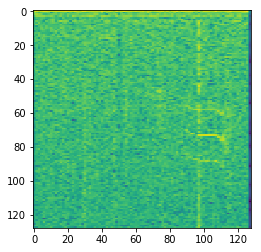

Prediction:  Orca


In [8]:
i = 920
print(filenames[i])
plt.imshow(SKRW[i])
plt.show()
print("Prediction: ", ["Noise", "Orca"][PredictOrca(SKRW[i], classifier)])

# Test Val

In [5]:
val_noise = [np.load(filename) for filename in glob.glob(os.getcwd() + "/data/val/noise/*.npy")]
val_orca = [np.load(filename) for filename in glob.glob(os.getcwd() + "/data/val/orca/*.npy")]
# train_noise = [np.load(filename) for filename in glob.glob(os.getcwd() + "/data/train/noise/*.npy")]
# train_orca = [np.load(filename) for filename in glob.glob(os.getcwd() + "/data/train/orca/*.npy")]

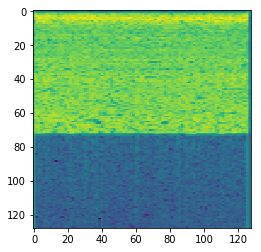

Prediction:  Noise


In [7]:
i = 4


plt.imshow(val_noise[i])
plt.show()
print("Prediction: ", ["Noise", "Orca"][PredictOrca(val_noise[i], classifier)])

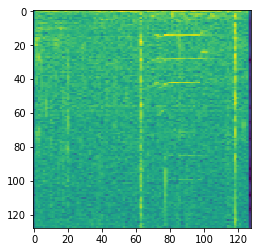

Prediction:  Orca


In [8]:
i = 10


plt.imshow(val_orca[i])
plt.show()
print("Prediction: ", ["Noise", "Orca"][PredictOrca(val_orca[i], classifier)])

# Get Validation Accuracy

In [9]:
from multiprocessing.pool import ThreadPool as Pool

In [10]:
pool_size = 128

def worker(val, val_result, label):
    try:
        if PredictOrca(val, classifier) == label:
            val_result.append(1)
        else:
            val_result.append(0)
    except:
        print('Error in: ', filename)



In [11]:
pool = Pool(pool_size)
val_result = []

for val in val_noise:
    pool.apply_async(worker, (val, val_result, 0,))

for val in val_orca:
    pool.apply_async(worker, (val, val_result, 1,))

pool.close()
pool.join()

In [12]:
print("Validation accuracy: ", np.mean(val_result))

Validation accuracy:  0.9027504911591355
